In [366]:
#! pip install -U --pre tensorflow tensorflow_datasets

In [367]:
#! pip install tensorflow==2.10

In [368]:
#import tensorflow
#print(tensorflow.__version__)

In [369]:
#! pip install nengo==3.2.0
#! pip install nengo-dl==3.6.0

In [370]:
#! apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.8
#! pip install seaborn
#! pip install matplotlib

In [371]:
#! pip install matplotlib --user --ignore-installed

In [372]:
#! pip install pydot
#! pip install graphviz

In [373]:
import os
import pathlib
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd

from matplotlib import rcParams
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import *
from tensorflow.python.client import device_lib

from keras.utils import plot_model


SAMPLE_RATE = 14000
MFCC_LEN    = 7
CHUNK_SIZE  = 1393
EPOCHS      = 40
SEED        = 0

model_save_path = './test_models/saved_model_2-10k-E'
DATASET_PATH = '../../Data/Test_dataset/02/'
DATASET_PATH_0 = DATASET_PATH + 'train' # learning dataset path
DATASET_PATH_1 = DATASET_PATH + 'test' # test dataset path

tf.random.set_seed(SEED)
np.random.seed(SEED)
rcParams.update({'figure.autolayout': True})

In [374]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


def get_mfcc(waveform, sr=SAMPLE_RATE, n_mfcc=13):
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    
    stft = tf.signal.stft(waveform, frame_length=512, frame_step=128, fft_length=512)
    spectrogram = tf.abs(stft)
    
    num_spectrogram_bins = stft.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0,SAMPLE_RATE/2 , 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz, upper_edge_hertz)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :n_mfcc]
    mfccs = mfccs[..., tf.newaxis]
    #mfccs = tf.reshape(mfccs, [-1, mfccs.shape[1], n_mfcc])
    
    return mfccs


def plot_mfcc(mfcc, ax):
    if len(mfcc.shape) > 2:
        assert len(mfcc.shape) == 3
        mfcc = np.squeeze(mfcc, axis=-1)
    log_spec = np.log(mfcc.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    x = np.linspace(0, np.size(mfcc), num=width, dtype=int)
    y = range(height)
    ax.pcolormesh(x, y, log_spec)


def make_mfcc_ds(ds):
    return ds.map(map_func=lambda audio,label: (get_mfcc(audio), label), num_parallel_calls=tf.data.AUTOTUNE)


def process_audio_chunks(audio_path):
    raw_audio = tf.io.read_file(str(audio_path))
    waveform, sr = tf.audio.decode_wav(raw_audio, desired_channels=1, desired_samples=SAMPLE_RATE)
    waveform = tf.squeeze(waveform, axis=-1)
    
    num_samples = tf.shape(waveform)[0]
    num_chunks = (num_samples + CHUNK_SIZE - 1) // CHUNK_SIZE
    pad_len = num_chunks * CHUNK_SIZE - num_samples
    waveform = tf.concat([waveform, tf.zeros(pad_len, dtype=tf.float32)], 0)
    
    waveform_chunks = tf.reshape(waveform, [num_chunks, CHUNK_SIZE])
    mfccs = tf.map_fn(get_mfcc, waveform_chunks, dtype=tf.float32)
    
    return mfccs, waveform

In [375]:
data_dir = pathlib.Path(DATASET_PATH_0)
if not data_dir.exists():
    print("Dataset Not Exists")
    exit()

labels_dir = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Labels:', labels_dir)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=pathlib.Path(DATASET_PATH_0),
    batch_size=256,
    seed=0,
    output_sequence_length=CHUNK_SIZE,
    subset='both',
    validation_split=0.3
)

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=pathlib.Path(DATASET_PATH_1),
    batch_size=256,
    seed=0,
    output_sequence_length=CHUNK_SIZE,
    subset=None,
    validation_split=None
)

label_names = np.array(train_ds.class_names)
print("label names:", label_names)

train_ds.element_spec

for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

label_names[[0,1]]

train_mfcc_ds = make_mfcc_ds(train_ds.map(squeeze, tf.data.AUTOTUNE))
val_mfcc_ds   = make_mfcc_ds(val_ds.map(squeeze, tf.data.AUTOTUNE))
test_mfcc_ds  = make_mfcc_ds(test_ds.map(squeeze, tf.data.AUTOTUNE))

Labels: ['_abnormal' '_normal']
Found 2098 files belonging to 2 classes.
Using 1469 files for training.
Using 629 files for validation.
Found 1361 files belonging to 2 classes.
label names: ['_abnormal' '_normal']
(256, 1393, 1)
(256,)


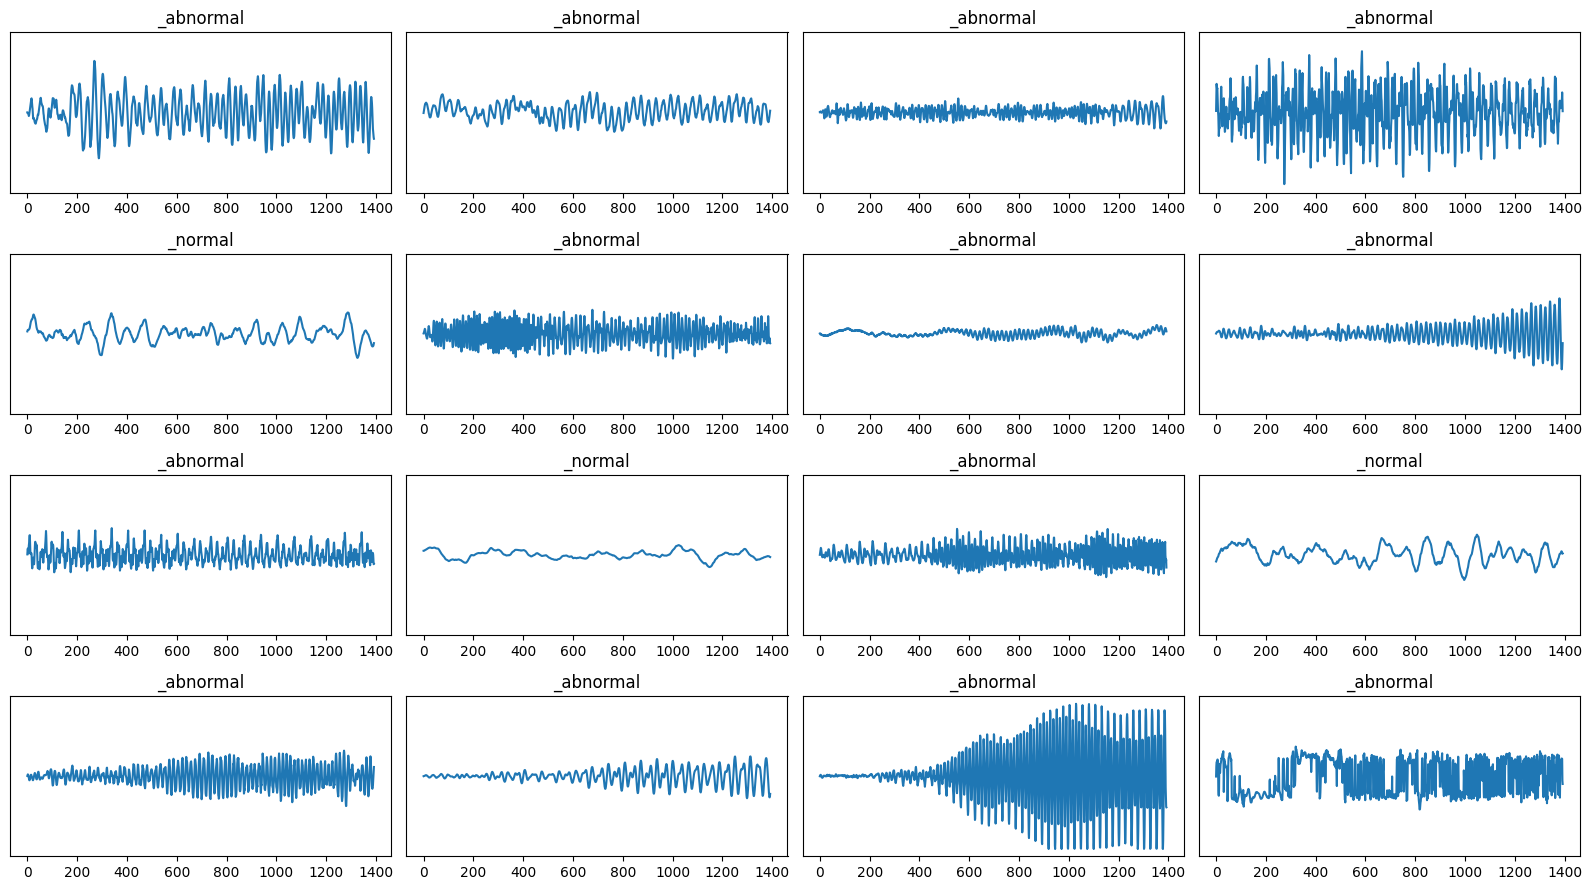

C:\Users\mosfet\AppData\Local\Temp\ipykernel_24272\3320868990.py:30: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(mfcc.T + np.finfo(float).eps)


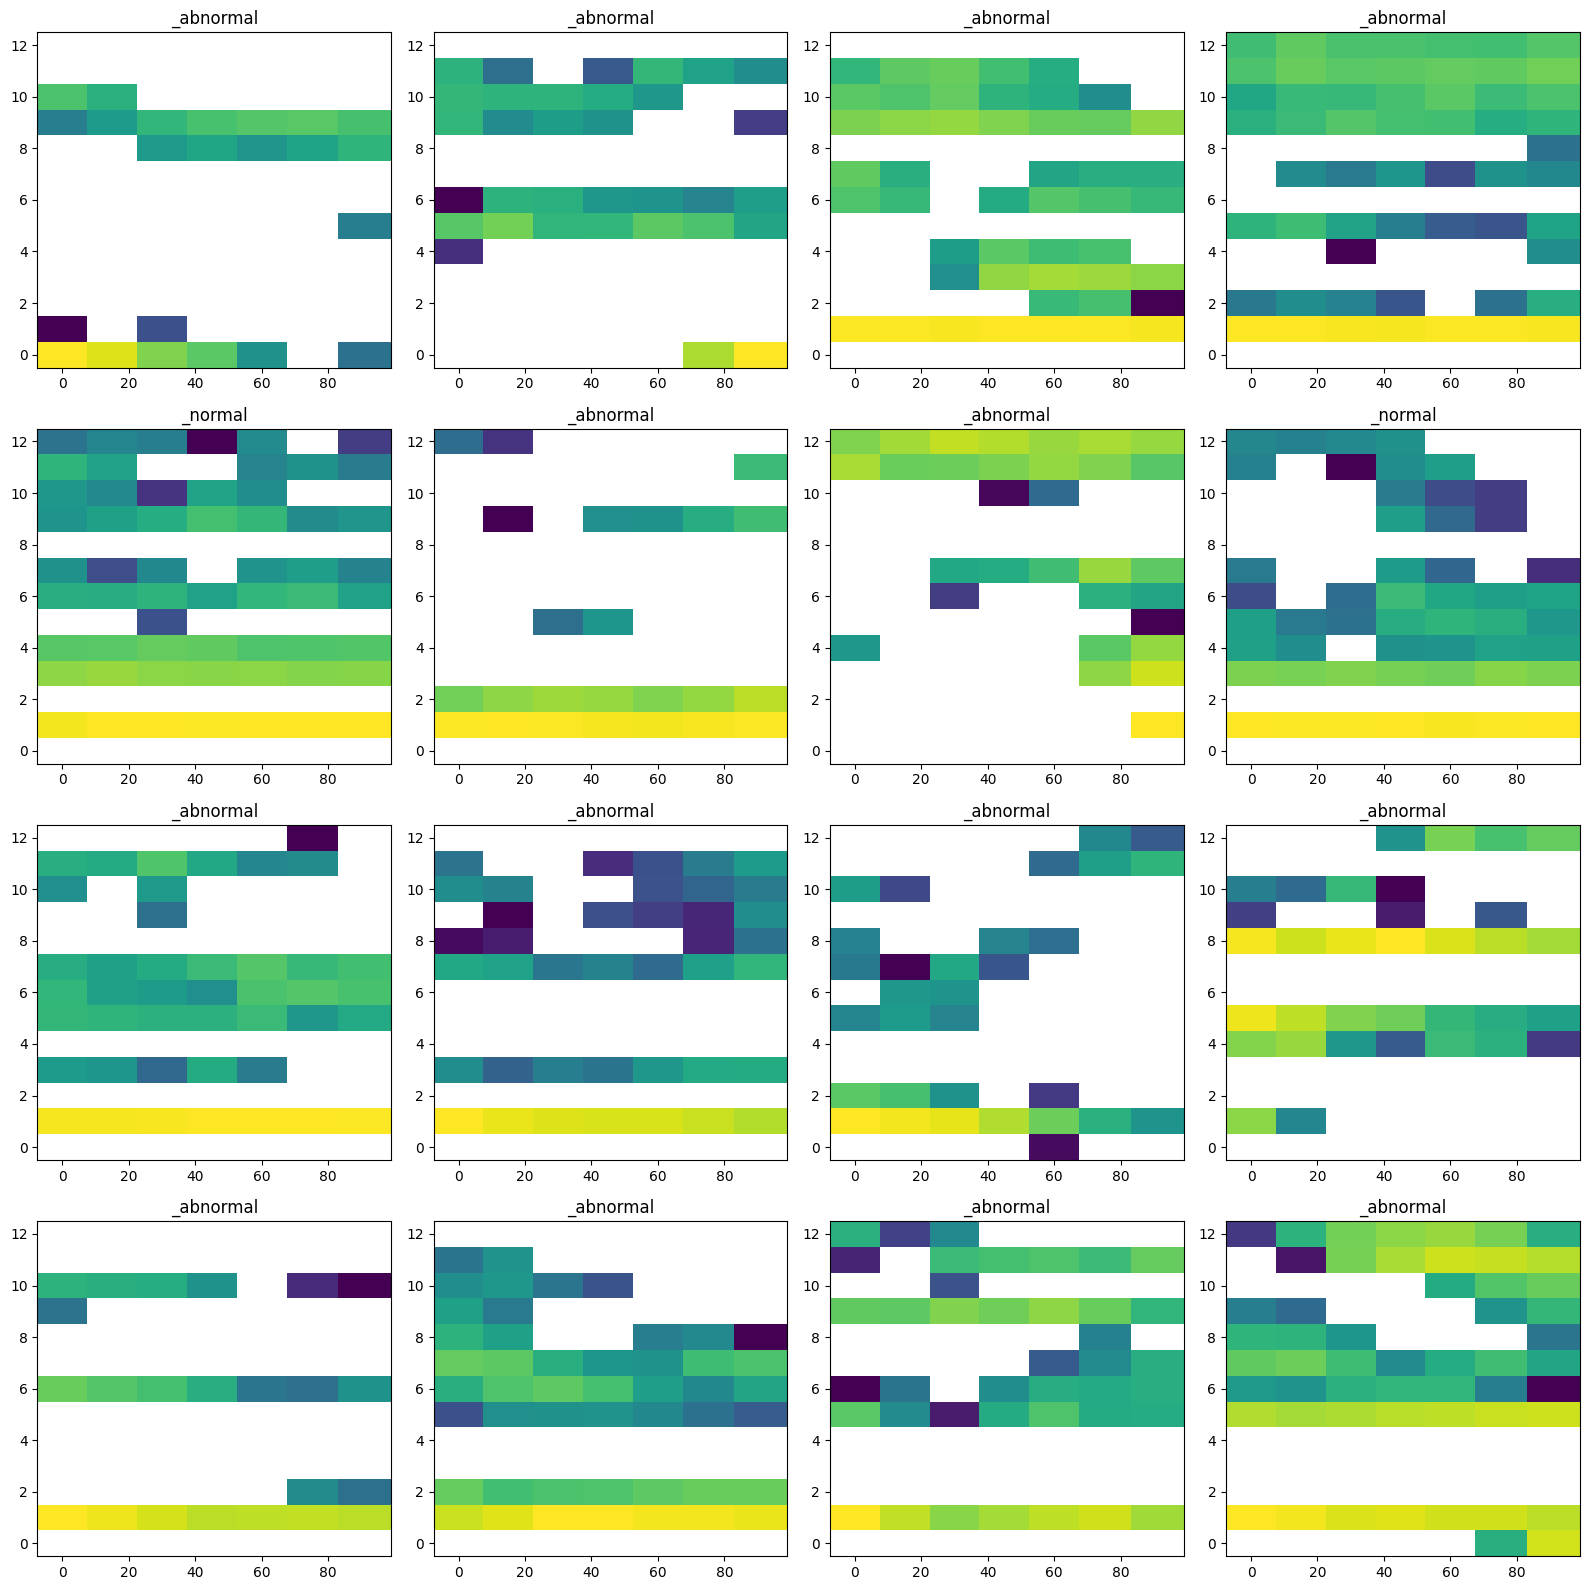

In [376]:
rows = 4
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if(i >= n):
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])
    ax.axes.yaxis.set_visible(False)

plt.show()


for example_mfcc, example_mfcc_labels in train_mfcc_ds.take(1):
    break

fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_mfcc(example_mfcc[i].numpy(), ax)
    ax.set_title(labels_dir[example_mfcc_labels[i].numpy()])

plt.show()

In [377]:
def leNetcustom(input_shape, num_labels, norm_layer):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Resizing(16, 16),

        norm_layer,
        tf.keras.layers.Conv2D(16, 2, activation='relu'),
        tf.keras.layers.Conv2D(8, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_labels, activation='softmax')
    ])
    return model

In [378]:
train_mfcc_ds = train_mfcc_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfcc_ds   = val_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)
test_mfcc_ds  = test_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_mfcc.shape[1:]
print('Input shape:', input_shape)

num_labels = len(labels_dir)
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_mfcc_ds.map(map_func=lambda spec, label: spec))

# model = xceptionNet(input_shape, num_labels, norm_layer)
model = leNetcustom(input_shape, num_labels, norm_layer)
# model = mobileNetCustom(input_shape, num_labels)
# model = squeezeNet(input_shape)
model.summary()

# plot_model(model, show_shapes=True)

Input shape: (7, 13, 1)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_21 (Resizing)      (None, 16, 16, 1)         0         
                                                                 
 normalization_21 (Normaliza  (None, 16, 16, 1)        3         
 tion)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 15, 15, 16)        80        
                                                                 
 conv2d_46 (Conv2D)          (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 8)          0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        

In [379]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    train_mfcc_ds,
    validation_data=val_mfcc_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/40


c:\Users\mosfet\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6/6 [==============================] - 1s 88ms/step - loss: 0.6521 - accuracy: 0.6617 - val_loss: 0.5896 - val_accuracy: 0.6804
Epoch 2/40
6/6 [==============================] - 0s 14ms/step - loss: 0.5535 - accuracy: 0.7229 - val_loss: 0.4932 - val_accuracy: 0.6804
Epoch 3/40
6/6 [==============================] - 0s 12ms/step - loss: 0.4624 - accuracy: 0.7413 - val_loss: 0.3902 - val_accuracy: 0.7122
Epoch 4/40
6/6 [==============================] - 0s 10ms/step - loss: 0.3583 - accuracy: 0.8121 - val_loss: 0.2735 - val_accuracy: 0.9762
Epoch 5/40
6/6 [==============================] - 0s 10ms/step - loss: 0.2540 - accuracy: 0.9353 - val_loss: 0.1693 - val_accuracy: 0.9952
Epoch 6/40
6/6 [==============================] - 0s 10ms/step - loss: 0.1654 - accuracy: 0.9762 - val_loss: 0.0923 - val_accuracy: 0.9936
Epoch 7/40
6/6 [==============================] - 0s 9ms/step - loss: 0.1103 - accuracy: 0.9714 - val_loss: 0.0535 - val_accuracy: 0.9936
Epoch 8/40
6/6 [=======================

Text(0, 0.5, 'Accuracy [%]')

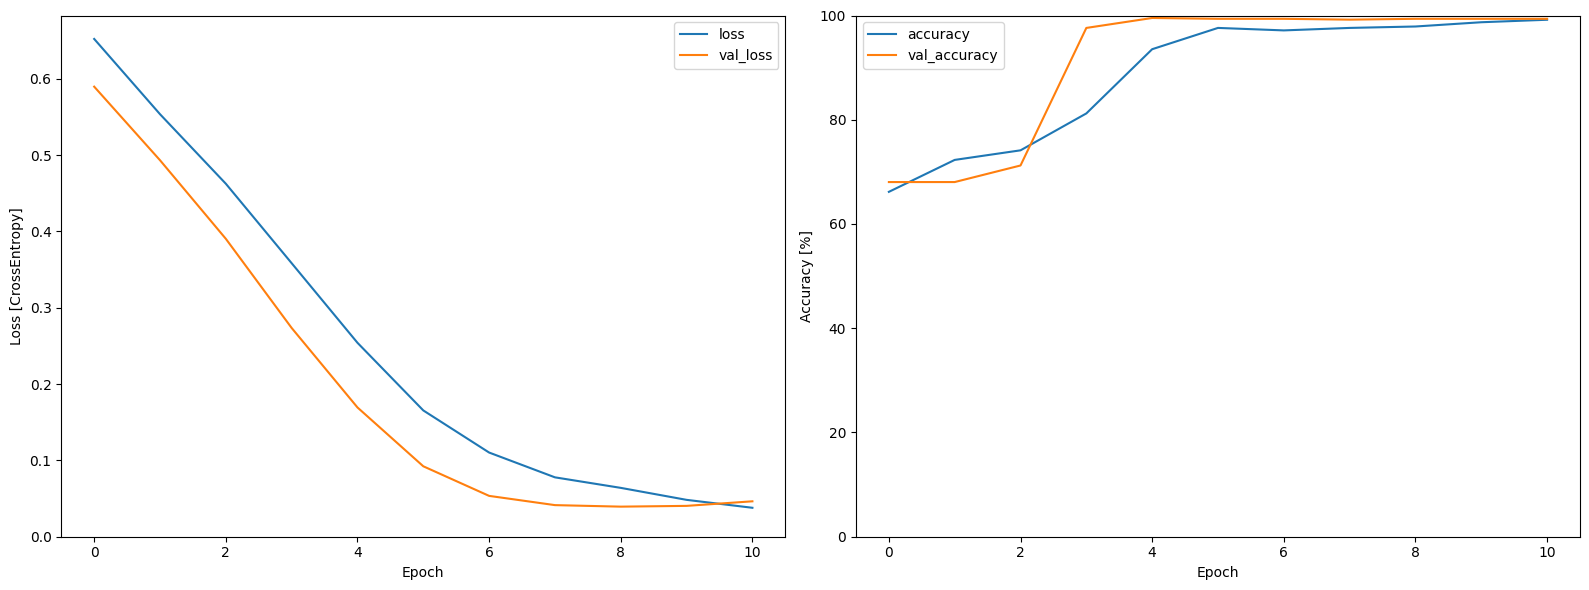

In [380]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

6/6 [==============================] - 0s 2ms/step


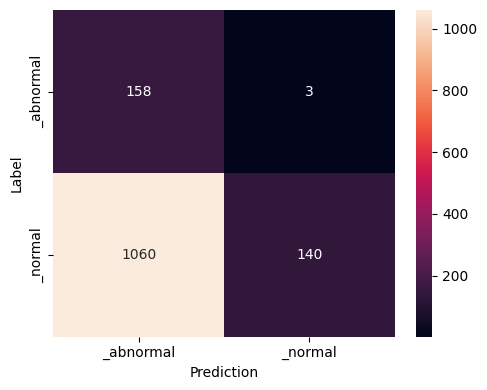

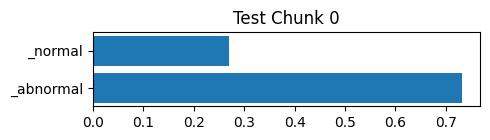

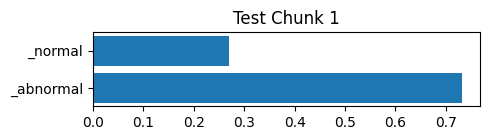

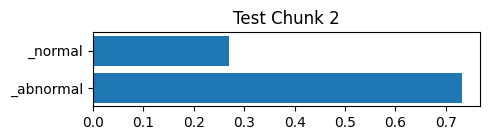

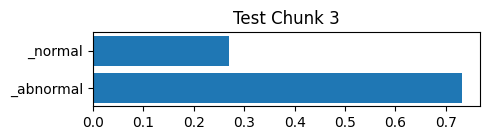

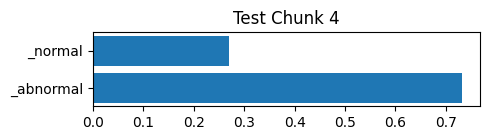

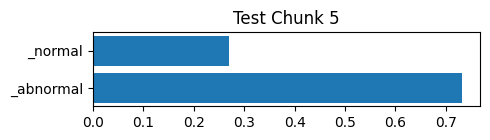

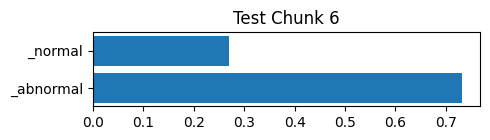

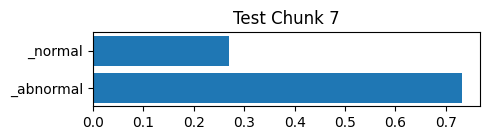

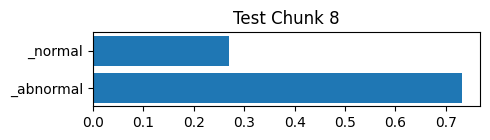

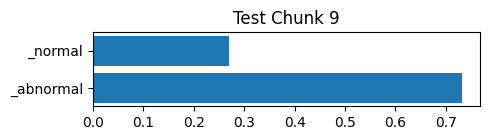

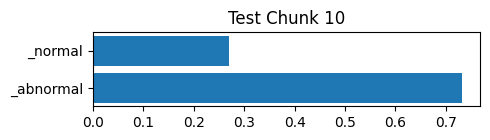

In [381]:
model.evaluate(test_mfcc_ds, return_dict=True)
y_pred = model.predict(test_mfcc_ds)

y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_mfcc_ds.map(lambda s, lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, xticklabels=labels_dir, yticklabels=labels_dir, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


x_path = data_dir/'_abnormal/AN_0020.wav'
x, waveform = process_audio_chunks(x_path)

predictions = [model(chunk[tf.newaxis, ...]) for chunk in x]

for i in range(len(predictions)):
    # plt.subplot(1, int(len(predictions)), int(i) + 1)
    plt.figure(figsize=(5, 1.5))
    plt.barh(labels_dir, tf.nn.softmax(predictions[i][0]))
    plt.title(f'Test Chunk {i}')

plt.show()

display.display(display.Audio(waveform, rate=SAMPLE_RATE))

In [382]:
'''
class KerasExportModel(tf.keras.Model):
    def call(self, x, training=False):
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLE_RATE)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]
        x = get_mfcc(x)
        return super().call(x, training)

# model = tf.keras.models.load_model('your_model_path')
export_model = KerasExportModel(inputs=model.input, outputs=model.output, name='export_model')
export_model.save('path_to_save')
'''

"\nclass KerasExportModel(tf.keras.Model):\n    def call(self, x, training=False):\n        if x.dtype == tf.string:\n            x = tf.io.read_file(x)\n            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLE_RATE)\n            x = tf.squeeze(x, axis=-1)\n            x = x[tf.newaxis, :]\n        x = get_mfcc(x)\n        return super().call(x, training)\n\n# model = tf.keras.models.load_model('your_model_path')\nexport_model = KerasExportModel(inputs=model.input, outputs=model.output, name='export_model')\nexport_model.save('path_to_save')\n"

In [383]:
'''
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, 14000], dtype=tf.float32))

    @tf.function
    def __call__(self, x):
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLE_RATE)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]

        x = get_mfcc(x)  
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions':result, 'class_ids': class_ids, 'class_names': class_names}


# model = tf.expand_dims(model, axis=-1)

export = ExportModel(model)
export(tf.constant(str(data_dir/'_abnormal/AN_0020.wav')))

tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])
'''


'\nclass ExportModel(tf.Module):\n    def __init__(self, model):\n        self.model = model\n\n        self.__call__.get_concrete_function(\n            x=tf.TensorSpec(shape=(), dtype=tf.string))\n        self.__call__.get_concrete_function(\n            x=tf.TensorSpec(shape=[None, 14000], dtype=tf.float32))\n\n    @tf.function\n    def __call__(self, x):\n        if x.dtype == tf.string:\n            x = tf.io.read_file(x)\n            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLE_RATE)\n            x = tf.squeeze(x, axis=-1)\n            x = x[tf.newaxis, :]\n\n        x = get_mfcc(x)  \n        result = self.model(x, training=False)\n\n        class_ids = tf.argmax(result, axis=-1)\n        class_names = tf.gather(label_names, class_ids)\n        return {\'predictions\':result, \'class_ids\': class_ids, \'class_names\': class_names}\n\n\n# model = tf.expand_dims(model, axis=-1)\n\nexport = ExportModel(model)\nexport(tf.constant(str(data_dir/\'_abnormal/

In [384]:
'''
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=(), dtype=tf.string)])
    def __call__(self, x):
        # 파일을 읽고 오디오 데이터를 디코딩
        x = tf.io.read_file(x)
        x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLE_RATE)
        x = tf.squeeze(x, axis=-1)
        
        # 오디오 데이터를 적절한 청크로 분할
        num_samples = tf.shape(x)[0]
        num_chunks = (num_samples + CHUNK_SIZE - 1) // CHUNK_SIZE
        pad_len = num_chunks * CHUNK_SIZE - num_samples
        x = tf.concat([x, tf.zeros(pad_len, dtype=tf.float32)], 0)
        x = tf.reshape(x, [num_chunks, CHUNK_SIZE])
        
        # 각 청크에 대해 MFCC를 계산하고 배치 차원 추가
        x = tf.map_fn(get_mfcc, x, dtype=tf.float32)
        x = x[..., tf.newaxis]  # 채널 차원 추가
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions': result, 'class_ids': class_ids, 'class_names': class_names}

# 모델 저장
model_save_path = 'my_trained_model'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# ExportModel 인스턴스 생성 및 저장
export = ExportModel(model)
tf.saved_model.save(export, "saved_model_path")
print("Export model saved to saved_model_path")

# 모델 불러오기
imported = tf.saved_model.load("saved_model_path")
print("Model loaded from saved_model_path")

# 예측 수행
x_path = str(data_dir / '_abnormal/AN_0020.wav')
predictions = imported(tf.constant(x_path))

# 결과 출력
print(f"Predictions: {predictions['predictions']}")
print(f"Class IDs: {predictions['class_ids']}")
print(f"Class Names: {predictions['class_names']}")
'''

'\nclass ExportModel(tf.Module):\n    def __init__(self, model):\n        self.model = model\n\n    @tf.function(input_signature=[tf.TensorSpec(shape=(), dtype=tf.string)])\n    def __call__(self, x):\n        # 파일을 읽고 오디오 데이터를 디코딩\n        x = tf.io.read_file(x)\n        x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLE_RATE)\n        x = tf.squeeze(x, axis=-1)\n        \n        # 오디오 데이터를 적절한 청크로 분할\n        num_samples = tf.shape(x)[0]\n        num_chunks = (num_samples + CHUNK_SIZE - 1) // CHUNK_SIZE\n        pad_len = num_chunks * CHUNK_SIZE - num_samples\n        x = tf.concat([x, tf.zeros(pad_len, dtype=tf.float32)], 0)\n        x = tf.reshape(x, [num_chunks, CHUNK_SIZE])\n        \n        # 각 청크에 대해 MFCC를 계산하고 배치 차원 추가\n        x = tf.map_fn(get_mfcc, x, dtype=tf.float32)\n        x = x[..., tf.newaxis]  # 채널 차원 추가\n        result = self.model(x, training=False)\n\n        class_ids = tf.argmax(result, axis=-1)\n        class_names = tf.gather(label_nam

In [385]:
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

INFO:tensorflow:Assets written to: ./test_models/saved_model_2-10k-E\assets


INFO:tensorflow:Assets written to: ./test_models/saved_model_2-10k-E\assets


Model saved to ./test_models/saved_model_2-10k-E


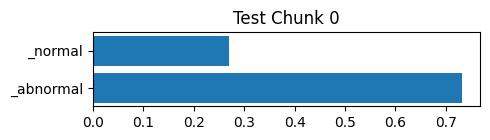

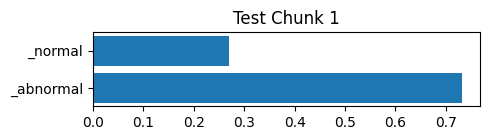

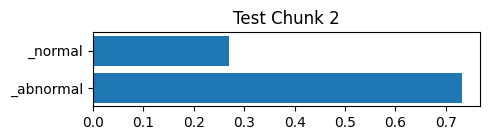

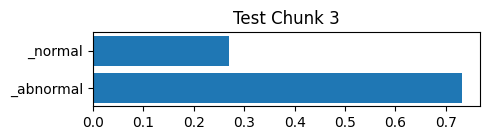

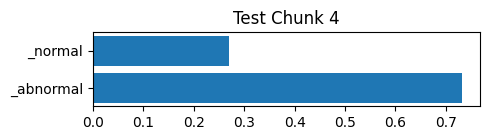

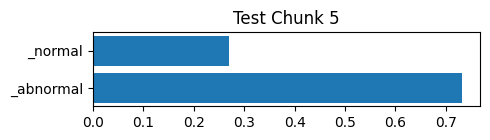

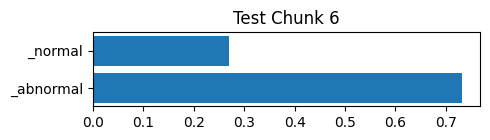

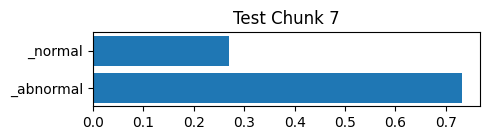

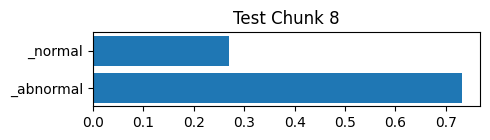

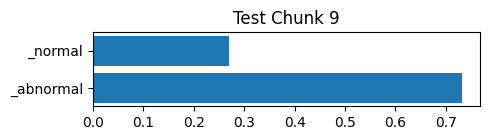

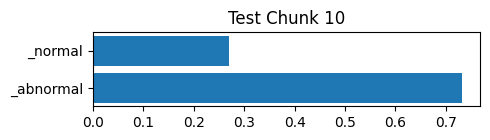

In [386]:
class ExportModel:
    def __init__(self, model_path, labels_dir, sample_rate=SAMPLE_RATE, chunk_size=CHUNK_SIZE):
        self.model = tf.keras.models.load_model(model_path)
        self.labels_dir = labels_dir
        self.sample_rate = sample_rate
        self.chunk_size = chunk_size

    def process_audio_chunks(self, audio_path):
        raw_audio = tf.io.read_file(str(audio_path))
        waveform, sr = tf.audio.decode_wav(raw_audio, desired_channels=1, desired_samples=self.sample_rate)
        waveform = tf.squeeze(waveform, axis=-1)
        
        num_samples = tf.shape(waveform)[0]
        num_chunks = (num_samples + self.chunk_size - 1) // self.chunk_size
        pad_len = num_chunks * self.chunk_size - num_samples
        waveform = tf.concat([waveform, tf.zeros(pad_len, dtype=tf.float32)], 0)
        
        waveform_chunks = tf.reshape(waveform, [num_chunks, self.chunk_size])
        mfccs = tf.map_fn(get_mfcc, waveform_chunks, dtype=tf.float32)
        
        return mfccs, waveform

    def predict(self, audio_path):
        mfccs, waveform = self.process_audio_chunks(audio_path)
        predictions = [self.model(chunk[tf.newaxis, ...]) for chunk in mfccs]

        return predictions, waveform

export_model = ExportModel(model_path=model_save_path, labels_dir=labels_dir)

audio_file_path = data_dir / '_abnormal/AN_0020.wav'
predictions, waveform = export_model.predict(audio_file_path)

for i, prediction in enumerate(predictions):
    plt.figure(figsize=(5, 1.5))
    plt.barh(export_model.labels_dir, tf.nn.softmax(prediction[0]))
    plt.title(f'Test Chunk {i}')

plt.show()

display.display(display.Audio(waveform, rate=SAMPLE_RATE))
